# Synthetic FX Carry + Tail Protection Backtest

Can the Spitznagel structure (carry + cheap OTM puts) work in FX?

We don't have FX options data yet, so this is a **synthetic backtest**: we use historical spot rates,
known interest rate differentials, and Black-Scholes to estimate what 10-delta puts would have cost.
Not as rigorous as real option chain backtesting, but enough to validate whether the numbers from
Jurek (2014) hold up.

**Pairs tested:**
- AUD/JPY — classic G10 carry pair, ~3-5% differential
- MXN/JPY — higher carry (~5-8%), more volatile, EM risk
- EUR/USD — low carry control, tests the structure without much rate differential

**Trade structure (per pair):**
1. Go long the high-yielder (earn rate differential daily)
2. Each month, buy a 10-delta OTM put (estimated via Black-Scholes + trailing realized vol)
3. At month end: put pays off if spot dropped below strike, otherwise expires worthless
4. Total return = carry + spot change + put payoff - put cost

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Download spot FX data
pairs = {
    'AUDJPY=X': 'AUD/JPY',
    'MXNJPY=X': 'MXN/JPY',
    'EURUSD=X': 'EUR/USD',
}

spot_data = {}
for ticker, name in pairs.items():
    df = yf.download(ticker, start='2005-01-01', progress=False)
    spot_data[name] = df['Close'].squeeze()
    print(f'{name}: {len(df)} rows, {df.index[0].date()} to {df.index[-1].date()}')

# Also get SPY for comparison
spy = yf.download('SPY', start='2005-01-01', progress=False)['Close'].squeeze()
print(f'SPY: {len(spy)} rows, {spy.index[0].date()} to {spy.index[-1].date()}')

AUD/JPY: 5507 rows, 2005-01-03 to 2026-02-28


MXN/JPY: 5503 rows, 2005-01-03 to 2026-02-27


EUR/USD: 5487 rows, 2005-01-03 to 2026-02-27


SPY: 5322 rows, 2005-01-03 to 2026-02-27


## Interest Rate Histories

We need the rate differential for each pair to compute daily carry. Using known central bank policy rates
as a proxy (the actual carry comes from forward points, which track the rate differential closely).

Sources: RBA (Australia), Banxico (Mexico), BOJ (Japan), ECB, Fed.

In [2]:
# Historical policy rates (approximate, using major rate change dates)
# These are simplified — actual rates have more granular steps,
# but this captures the major regimes accurately enough for a synthetic backtest.

def build_rate_series(changes, start='2005-01-01', end='2026-03-01'):
    """Build a daily rate series from a list of (date, rate) changes."""
    idx = pd.date_range(start, end, freq='B')
    s = pd.Series(np.nan, index=idx)
    for date, rate in changes:
        s.loc[date:] = rate / 100  # convert to decimal
    return s.ffill()

# RBA Cash Rate (Australia)
rba_changes = [
    ('2005-01-01', 5.25), ('2005-03-02', 5.50), ('2008-03-05', 7.25),
    ('2008-09-03', 7.00), ('2008-10-08', 6.00), ('2008-11-05', 5.25),
    ('2008-12-03', 4.25), ('2009-02-04', 3.25), ('2009-04-08', 3.00),
    ('2009-10-07', 3.25), ('2009-11-04', 3.50), ('2009-12-02', 3.75),
    ('2010-03-03', 4.00), ('2010-04-07', 4.25), ('2010-05-05', 4.50),
    ('2010-11-03', 4.75), ('2011-05-04', 4.75), ('2011-11-02', 4.50),
    ('2011-12-06', 4.25), ('2012-05-02', 3.75), ('2012-06-06', 3.50),
    ('2012-10-03', 3.25), ('2012-12-05', 3.00), ('2013-05-08', 2.75),
    ('2013-08-07', 2.50), ('2014-08-06', 2.50), ('2015-02-04', 2.25),
    ('2015-05-06', 2.00), ('2016-05-04', 1.75), ('2016-08-03', 1.50),
    ('2019-06-05', 1.25), ('2019-07-03', 1.00), ('2019-10-02', 0.75),
    ('2020-03-04', 0.50), ('2020-03-20', 0.25), ('2020-11-04', 0.10),
    ('2022-05-04', 0.35), ('2022-06-08', 0.85), ('2022-07-06', 1.35),
    ('2022-08-03', 1.85), ('2022-09-07', 2.35), ('2022-10-05', 2.60),
    ('2022-11-02', 2.85), ('2022-12-07', 3.10), ('2023-02-08', 3.35),
    ('2023-03-08', 3.60), ('2023-05-03', 3.85), ('2023-06-07', 4.10),
    ('2023-11-08', 4.35), ('2024-06-20', 4.35), ('2025-02-18', 4.10),
]

# BOJ Policy Rate (Japan)
boj_changes = [
    ('2005-01-01', 0.00), ('2006-07-14', 0.25), ('2007-02-21', 0.50),
    ('2008-10-31', 0.30), ('2008-12-19', 0.10), ('2016-02-16', -0.10),
    ('2024-03-19', 0.00), ('2024-07-31', 0.25), ('2025-01-24', 0.50),
]

# Banxico Policy Rate (Mexico)
banxico_changes = [
    ('2005-01-01', 8.75), ('2005-03-25', 9.25), ('2005-08-26', 9.50),
    ('2005-10-28', 9.25), ('2005-12-09', 9.00), ('2006-01-27', 8.75),
    ('2006-02-24', 8.50), ('2006-03-24', 8.25), ('2006-04-21', 7.75),
    ('2006-07-28', 7.50), ('2006-09-22', 7.25), ('2006-10-27', 7.00),
    ('2007-10-26', 7.50), ('2008-06-20', 8.00), ('2008-07-18', 8.25),
    ('2009-01-16', 7.75), ('2009-02-20', 7.50), ('2009-03-20', 6.75),
    ('2009-04-17', 6.00), ('2009-05-15', 5.50), ('2009-06-19', 4.75),
    ('2009-07-17', 4.50), ('2013-03-08', 4.00), ('2013-09-06', 3.75),
    ('2013-10-25', 3.50), ('2014-06-06', 3.00), ('2015-12-17', 3.25),
    ('2016-02-18', 3.75), ('2016-06-30', 4.25), ('2016-09-29', 4.75),
    ('2016-11-17', 5.25), ('2016-12-15', 5.75), ('2017-02-09', 6.25),
    ('2017-03-30', 6.50), ('2017-05-18', 6.75), ('2017-06-22', 7.00),
    ('2017-12-14', 7.25), ('2018-02-08', 7.50), ('2018-06-21', 7.75),
    ('2018-11-15', 8.00), ('2018-12-20', 8.25), ('2019-08-15', 8.00),
    ('2019-09-26', 7.75), ('2019-11-14', 7.50), ('2019-12-19', 7.25),
    ('2020-02-13', 7.00), ('2020-03-20', 6.50), ('2020-04-21', 6.00),
    ('2020-05-14', 5.50), ('2020-06-25', 5.00), ('2020-09-24', 4.25),
    ('2020-11-12', 4.25), ('2021-06-24', 4.25), ('2021-12-16', 5.50),
    ('2022-02-10', 6.00), ('2022-03-24', 6.50), ('2022-05-12', 7.00),
    ('2022-06-23', 7.75), ('2022-08-11', 8.50), ('2022-09-29', 9.25),
    ('2022-11-10', 10.00), ('2022-12-15', 10.50), ('2023-01-09', 10.50),
    ('2023-03-30', 11.25), ('2023-05-18', 11.25), ('2024-03-21', 11.00),
    ('2024-06-27', 11.00), ('2024-08-08', 10.75), ('2024-09-26', 10.50),
    ('2024-11-14', 10.25), ('2024-12-19', 10.00), ('2025-02-06', 9.50),
]

# Fed Funds Rate (US)
fed_changes = [
    ('2005-01-01', 2.25), ('2005-02-02', 2.50), ('2005-03-22', 2.75),
    ('2005-05-03', 3.00), ('2005-06-30', 3.25), ('2005-08-09', 3.50),
    ('2005-09-20', 3.75), ('2005-11-01', 4.00), ('2005-12-13', 4.25),
    ('2006-01-31', 4.50), ('2006-03-28', 4.75), ('2006-05-10', 5.00),
    ('2006-06-29', 5.25), ('2007-09-18', 4.75), ('2007-10-31', 4.50),
    ('2007-12-11', 4.25), ('2008-01-22', 3.50), ('2008-01-30', 3.00),
    ('2008-03-18', 2.25), ('2008-04-30', 2.00), ('2008-10-08', 1.50),
    ('2008-10-29', 1.00), ('2008-12-16', 0.25), ('2015-12-17', 0.50),
    ('2016-12-14', 0.75), ('2017-03-16', 1.00), ('2017-06-15', 1.25),
    ('2017-12-14', 1.50), ('2018-03-22', 1.75), ('2018-06-14', 2.00),
    ('2018-09-27', 2.25), ('2018-12-20', 2.50), ('2019-08-01', 2.25),
    ('2019-09-19', 2.00), ('2019-10-31', 1.75), ('2020-03-03', 1.25),
    ('2020-03-16', 0.25), ('2022-03-17', 0.50), ('2022-05-05', 1.00),
    ('2022-06-16', 1.75), ('2022-07-27', 2.50), ('2022-09-21', 3.25),
    ('2022-11-02', 4.00), ('2022-12-14', 4.50), ('2023-02-01', 4.75),
    ('2023-03-22', 5.00), ('2023-05-03', 5.25), ('2023-07-26', 5.50),
    ('2024-09-18', 5.00), ('2024-11-07', 4.75), ('2024-12-18', 4.50),
]

# ECB Main Refinancing Rate
ecb_changes = [
    ('2005-01-01', 2.00), ('2005-12-06', 2.25), ('2006-03-08', 2.50),
    ('2006-06-15', 2.75), ('2006-08-09', 3.00), ('2006-10-11', 3.25),
    ('2006-12-13', 3.50), ('2007-03-14', 3.75), ('2007-06-13', 4.00),
    ('2008-07-09', 4.25), ('2008-10-08', 3.75), ('2008-11-12', 3.25),
    ('2008-12-10', 2.50), ('2009-01-21', 2.00), ('2009-03-11', 1.50),
    ('2009-04-08', 1.25), ('2009-05-13', 1.00), ('2011-04-13', 1.25),
    ('2011-07-13', 1.50), ('2011-11-09', 1.25), ('2011-12-14', 1.00),
    ('2012-07-11', 0.75), ('2013-05-08', 0.50), ('2013-11-13', 0.25),
    ('2014-06-11', 0.15), ('2014-09-10', 0.05), ('2016-03-16', 0.00),
    ('2022-07-27', 0.50), ('2022-09-14', 1.25), ('2022-11-02', 2.00),
    ('2022-12-21', 2.50), ('2023-02-08', 3.00), ('2023-03-22', 3.50),
    ('2023-05-10', 3.75), ('2023-06-21', 4.00), ('2023-07-27', 4.25),
    ('2023-09-20', 4.50), ('2024-06-12', 4.25), ('2024-09-18', 3.65),
    ('2024-10-23', 3.40), ('2024-12-18', 3.15), ('2025-01-30', 2.90),
]

rate_aud = build_rate_series(rba_changes)
rate_jpy = build_rate_series(boj_changes)
rate_mxn = build_rate_series(banxico_changes)
rate_usd = build_rate_series(fed_changes)
rate_eur = build_rate_series(ecb_changes)

# Rate differentials (what the carry trader earns)
carry_diff = {
    'AUD/JPY': (rate_aud - rate_jpy),
    'MXN/JPY': (rate_mxn - rate_jpy),
    'EUR/USD': (rate_eur - rate_usd),  # can be negative
}

# Quick check
for name, diff in carry_diff.items():
    print(f'{name} carry — current: {diff.iloc[-1]*100:.2f}%, mean: {diff.mean()*100:.2f}%, min: {diff.min()*100:.2f}%, max: {diff.max()*100:.2f}%')

AUD/JPY carry — current: 3.60%, mean: 3.08%, min: 0.20%, max: 6.75%
MXN/JPY carry — current: 9.00%, mean: 6.46%, min: 2.90%, max: 11.35%
EUR/USD carry — current: -1.60%, mean: -0.55%, min: -2.50%, max: 2.75%


## Black-Scholes Put Pricing

We estimate monthly 10-delta put costs using:
- **Trailing 60-day realized volatility** as a proxy for implied vol (conservative — implied is usually higher)
- **10-delta strike**: for a normal distribution, 10-delta corresponds to ~1.28 standard deviations OTM
- **1-month tenor** (T = 1/12 year)

Strike = Spot × (1 - 1.28 × σ × √T)

This is an approximation. Real FX options are quoted in terms of delta and risk reversals, and
implied vol has its own smile/skew. But for a first-pass synthetic backtest, this is reasonable.

Jurek (2014) found that **3-month options are 1-2%/yr cheaper** than 1-month rolling. We start with
1-month for simplicity and can test 3-month later.

In [3]:
def bs_put_price(S, K, T, r, sigma):
    """Black-Scholes put price. r is domestic risk-free rate."""
    if sigma <= 0 or T <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def strike_for_delta(S, T, sigma, delta=0.10, r=0.0):
    """Approximate strike for a given put delta (absolute value)."""
    # For put: delta = -N(-d1), so N(-d1) = |delta|
    # -d1 = norm.ppf(|delta|), so d1 = -norm.ppf(|delta|)
    d1 = -norm.ppf(delta)
    K = S * np.exp(-d1 * sigma * np.sqrt(T) + (r + 0.5 * sigma**2) * T)
    return K


def synthetic_carry_backtest(spot, carry_differential, pair_name,
                             put_delta=0.10, tenor_months=1,
                             vol_lookback=60, put_budget_pct=None):
    """
    Synthetic backtest: FX carry trade + monthly OTM put protection.
    
    Parameters:
    - spot: daily spot prices (pd.Series)
    - carry_differential: daily annualized rate differential (pd.Series)  
    - put_delta: option delta for strike selection (0.10 = 10-delta)
    - tenor_months: option tenor in months
    - vol_lookback: days for trailing realized vol
    - put_budget_pct: if set, fix put spending at this % of portfolio/yr
                      (overrides BS pricing — useful for comparison with SPY backtest)
    
    Returns dict with daily returns for: unhedged carry, hedged carry, spot only.
    """
    # Align dates
    common = spot.index.intersection(carry_differential.index)
    spot = spot.loc[common].copy()
    carry = carry_differential.loc[common].copy()
    
    # Daily spot returns
    spot_ret = spot.pct_change().fillna(0)
    
    # Daily carry (annualized differential / 252)
    daily_carry = carry / 252
    
    # Trailing realized vol (annualized)
    realized_vol = spot_ret.rolling(vol_lookback).std() * np.sqrt(252)
    
    # Unhedged carry trade return = spot return + daily carry
    unhedged_ret = spot_ret + daily_carry
    
    # Monthly put hedging
    T = tenor_months / 12  # years
    monthly_groups = spot.groupby(pd.Grouper(freq='ME'))
    
    # Track put P&L
    put_pnl = pd.Series(0.0, index=spot.index)  # daily put contribution
    put_cost_total = 0.0
    put_payoff_total = 0.0
    months_traded = 0
    
    for month_end, group in monthly_groups:
        if len(group) < 5:  # skip partial months
            continue
        
        entry_date = group.index[0]
        exit_date = group.index[-1]
        
        # Get vol estimate at entry
        if entry_date not in realized_vol.index or pd.isna(realized_vol.loc[entry_date]):
            continue
        
        sigma = realized_vol.loc[entry_date]
        if sigma <= 0.01:  # skip if vol is unreasonably low
            continue
        
        S_entry = spot.loc[entry_date]
        S_exit = spot.loc[exit_date]
        
        # Compute strike and put price
        K = strike_for_delta(S_entry, T, sigma, delta=put_delta)
        put_price = bs_put_price(S_entry, K, T, r=0.0, sigma=sigma)
        
        # Put cost as fraction of spot
        cost_pct = put_price / S_entry
        
        # If budget is fixed, scale the number of puts
        if put_budget_pct is not None:
            monthly_budget = put_budget_pct / 12  # monthly fraction
            if cost_pct > 0:
                n_puts = monthly_budget / cost_pct  # fraction of notional protected
            else:
                n_puts = 0
        else:
            n_puts = 1.0  # hedge full notional
            monthly_budget = cost_pct
        
        # Put payoff at expiry
        intrinsic = max(0, K - S_exit)
        payoff_pct = (intrinsic / S_entry) * n_puts
        
        # Distribute cost evenly across trading days, payoff on last day
        n_days = len(group)
        daily_cost = (cost_pct * n_puts) / n_days
        
        for d in group.index:
            put_pnl.loc[d] = -daily_cost
        put_pnl.loc[exit_date] += payoff_pct
        
        put_cost_total += cost_pct * n_puts
        put_payoff_total += payoff_pct
        months_traded += 1
    
    # Hedged return = unhedged + put P&L
    hedged_ret = unhedged_ret + put_pnl
    
    # Build cumulative series
    cum_unhedged = (1 + unhedged_ret).cumprod()
    cum_hedged = (1 + hedged_ret).cumprod()
    cum_spot = (1 + spot_ret).cumprod()
    
    # Stats
    years = len(spot) / 252
    
    def calc_stats(daily_ret, label):
        cum = (1 + daily_ret).cumprod()
        total_ret = cum.iloc[-1] - 1
        cagr = (cum.iloc[-1]) ** (1/years) - 1
        vol = daily_ret.std() * np.sqrt(252)
        sharpe = cagr / vol if vol > 0 else 0
        # Max drawdown
        peak = cum.cummax()
        dd = (cum - peak) / peak
        max_dd = dd.min()
        return {
            'Strategy': label,
            'CAGR': f'{cagr*100:.2f}%',
            'Volatility': f'{vol*100:.2f}%',
            'Sharpe': f'{sharpe:.3f}',
            'Max DD': f'{max_dd*100:.1f}%',
            'Total Return': f'{total_ret*100:.1f}%',
            '_cagr': cagr, '_vol': vol, '_sharpe': sharpe, '_max_dd': max_dd,
        }
    
    stats = [
        calc_stats(spot_ret, f'{pair_name} spot only'),
        calc_stats(unhedged_ret, f'{pair_name} carry (unhedged)'),
        calc_stats(hedged_ret, f'{pair_name} carry + puts'),
    ]
    
    avg_annual_cost = put_cost_total / years * 100
    avg_annual_payoff = put_payoff_total / years * 100
    
    return {
        'stats': stats,
        'cum_unhedged': cum_unhedged,
        'cum_hedged': cum_hedged,
        'cum_spot': cum_spot,
        'put_cost_annual': avg_annual_cost,
        'put_payoff_annual': avg_annual_payoff,
        'months_traded': months_traded,
        'daily_hedged': hedged_ret,
        'daily_unhedged': unhedged_ret,
    }

print('Backtest engine ready.')

Backtest engine ready.


## Run Backtests: All Three Pairs

In [4]:
results = {}
all_stats = []

for pair_name in ['AUD/JPY', 'MXN/JPY', 'EUR/USD']:
    spot = spot_data[pair_name]
    carry = carry_diff[pair_name]
    
    res = synthetic_carry_backtest(spot, carry, pair_name, put_delta=0.10, tenor_months=1)
    results[pair_name] = res
    all_stats.extend(res['stats'])
    
    print(f"\n{'='*60}")
    print(f"{pair_name}")
    print(f"{'='*60}")
    print(f"  Months traded: {res['months_traded']}")
    print(f"  Avg annual put cost:   {res['put_cost_annual']:.2f}% of notional")
    print(f"  Avg annual put payoff: {res['put_payoff_annual']:.2f}% of notional")
    print(f"  Net hedging cost:      {res['put_cost_annual'] - res['put_payoff_annual']:.2f}%/yr")

# SPY baseline
spy_ret = spy.pct_change().fillna(0)
spy_cum = (1 + spy_ret).cumprod()
spy_years = len(spy) / 252
spy_cagr = spy_cum.iloc[-1] ** (1/spy_years) - 1
spy_vol = spy_ret.std() * np.sqrt(252)
spy_sharpe = spy_cagr / spy_vol
spy_peak = spy_cum.cummax()
spy_max_dd = ((spy_cum - spy_peak) / spy_peak).min()

all_stats.append({
    'Strategy': 'SPY (buy & hold)',
    'CAGR': f'{spy_cagr*100:.2f}%',
    'Volatility': f'{spy_vol*100:.2f}%',
    'Sharpe': f'{spy_sharpe:.3f}',
    'Max DD': f'{spy_max_dd*100:.1f}%',
    'Total Return': f'{(spy_cum.iloc[-1]-1)*100:.1f}%',
    '_cagr': spy_cagr, '_vol': spy_vol, '_sharpe': spy_sharpe, '_max_dd': spy_max_dd,
})

all_stats.append({
    'Strategy': 'SPY + 0.5% puts (from backtester)',
    'CAGR': '16.00%',
    'Volatility': '~14%',
    'Sharpe': '1.879',
    'Max DD': '~-20%',
    'Total Return': 'N/A (2008-2025)',
    '_cagr': 0.16, '_vol': 0.14, '_sharpe': 1.879, '_max_dd': -0.20,
})


AUD/JPY
  Months traded: 251
  Avg annual put cost:   2.12% of notional
  Avg annual put payoff: 2.64% of notional
  Net hedging cost:      -0.52%/yr



MXN/JPY
  Months traded: 251
  Avg annual put cost:   2.41% of notional
  Avg annual put payoff: 3.52% of notional
  Net hedging cost:      -1.11%/yr



EUR/USD
  Months traded: 251
  Avg annual put cost:   1.47% of notional
  Avg annual put payoff: 1.39% of notional
  Net hedging cost:      0.08%/yr


In [5]:
# Results table
display_cols = ['Strategy', 'CAGR', 'Volatility', 'Sharpe', 'Max DD', 'Total Return']
df_stats = pd.DataFrame(all_stats)[display_cols]
print(df_stats.to_string(index=False))

                         Strategy   CAGR Volatility Sharpe Max DD    Total Return
                AUD/JPY spot only  1.51%     15.38%  0.098 -47.6%           38.7%
         AUD/JPY carry (unhedged)  4.68%     15.38%  0.305 -44.9%          171.9%
             AUD/JPY carry + puts  5.17%     15.76%  0.328 -41.3%          200.7%
                MXN/JPY spot only -0.04%     16.47% -0.003 -62.9%           -0.9%
         MXN/JPY carry (unhedged)  6.62%     16.47%  0.402 -41.9%          305.2%
             MXN/JPY carry + puts  7.72%     16.99%  0.454 -35.2%          407.4%
                EUR/USD spot only -0.60%     11.09% -0.055 -40.0%          -12.4%
         EUR/USD carry (unhedged) -1.16%     11.09% -0.104 -41.7%          -22.4%
             EUR/USD carry + puts -1.25%     11.19% -0.112 -39.5%          -24.0%
                 SPY (buy & hold) 10.61%     19.01%  0.558 -55.2%          740.6%
SPY + 0.5% puts (from backtester) 16.00%       ~14%  1.879  ~-20% N/A (2008-2025)


## Equity Curves

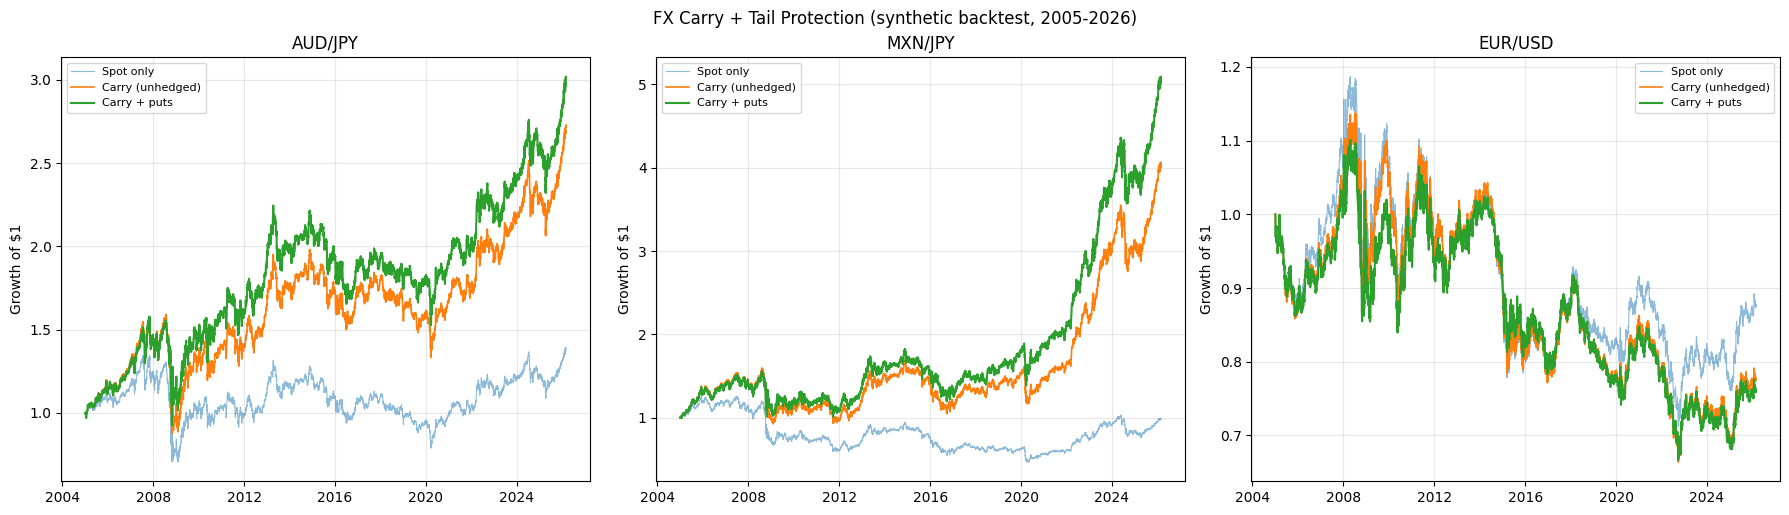

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, pair_name in zip(axes, ['AUD/JPY', 'MXN/JPY', 'EUR/USD']):
    res = results[pair_name]
    ax.plot(res['cum_spot'], label='Spot only', alpha=0.5, linewidth=0.8)
    ax.plot(res['cum_unhedged'], label='Carry (unhedged)', linewidth=1.2)
    ax.plot(res['cum_hedged'], label='Carry + puts', linewidth=1.5)
    ax.set_title(pair_name)
    ax.legend(fontsize=8)
    ax.set_ylabel('Growth of $1')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('FX Carry + Tail Protection (synthetic backtest, 2005-2026)', y=1.02)
plt.show()

## Drawdown Analysis

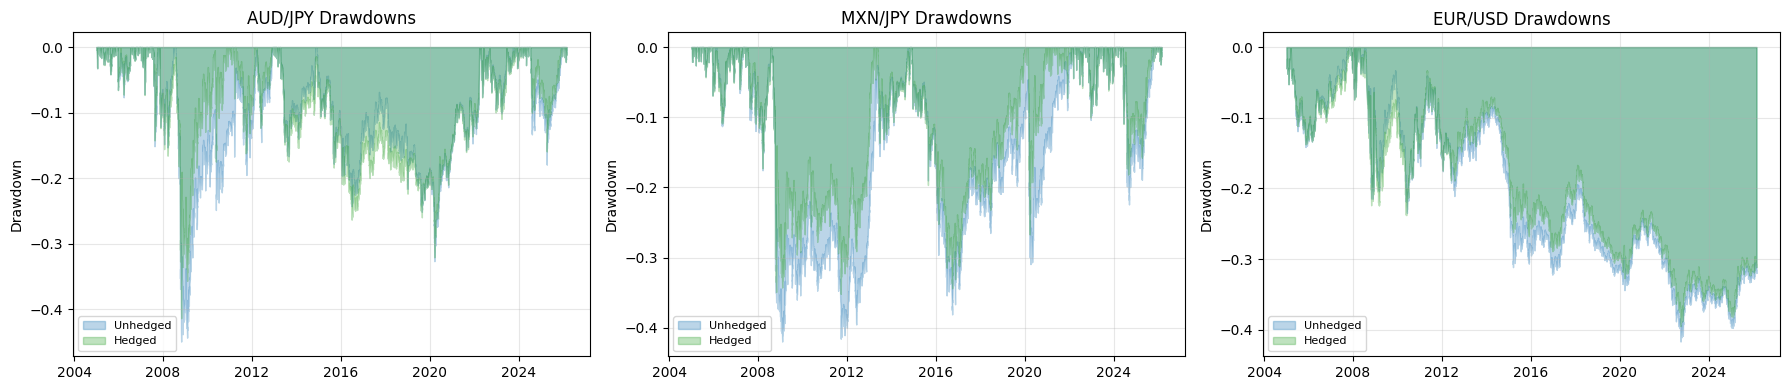

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for ax, pair_name in zip(axes, ['AUD/JPY', 'MXN/JPY', 'EUR/USD']):
    res = results[pair_name]
    for series, label, color in [
        (res['cum_unhedged'], 'Unhedged', 'tab:blue'),
        (res['cum_hedged'], 'Hedged', 'tab:green'),
    ]:
        peak = series.cummax()
        dd = (series - peak) / peak
        ax.fill_between(dd.index, dd, 0, alpha=0.3, label=label, color=color)
    ax.set_title(f'{pair_name} Drawdowns')
    ax.legend(fontsize=8)
    ax.set_ylabel('Drawdown')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Sensitivity: 10-delta vs 25-delta puts

In [8]:
# Compare 10-delta (cheap, far OTM) vs 25-delta (closer, more expensive)
sensitivity_stats = []

for pair_name in ['AUD/JPY', 'MXN/JPY']:
    spot = spot_data[pair_name]
    carry = carry_diff[pair_name]
    
    for delta in [0.05, 0.10, 0.25]:
        res = synthetic_carry_backtest(spot, carry, pair_name, put_delta=delta)
        s = res['stats'][2]  # hedged stats
        sensitivity_stats.append({
            'Pair': pair_name,
            'Delta': f'{int(delta*100)}d',
            'CAGR': s['CAGR'],
            'Sharpe': s['Sharpe'],
            'Max DD': s['Max DD'],
            'Put Cost/yr': f"{res['put_cost_annual']:.2f}%",
            'Put Payoff/yr': f"{res['put_payoff_annual']:.2f}%",
            'Net Cost/yr': f"{res['put_cost_annual'] - res['put_payoff_annual']:.2f}%",
        })

print(pd.DataFrame(sensitivity_stats).to_string(index=False))

   Pair Delta  CAGR Sharpe Max DD Put Cost/yr Put Payoff/yr Net Cost/yr
AUD/JPY    5d 5.44%  0.349 -41.4%       0.93%         1.69%      -0.75%
AUD/JPY   10d 5.17%  0.328 -41.3%       2.12%         2.64%      -0.52%
AUD/JPY   25d 3.87%  0.237 -41.0%       6.72%         6.08%       0.64%
MXN/JPY    5d 7.70%  0.459 -36.4%       1.06%         2.12%      -1.06%
MXN/JPY   10d 7.72%  0.454 -35.2%       2.41%         3.52%      -1.11%
MXN/JPY   25d 6.23%  0.353 -41.7%       7.63%         7.45%       0.18%


## Sensitivity: 1-month vs 3-month tenor

Jurek (2014) found 3-month options are 1-2%/yr cheaper because carry crashes unfold over weeks, not overnight.

In [9]:
tenor_stats = []

for pair_name in ['AUD/JPY', 'MXN/JPY']:
    spot = spot_data[pair_name]
    carry = carry_diff[pair_name]
    
    for tenor in [1, 3]:
        res = synthetic_carry_backtest(spot, carry, pair_name, put_delta=0.10, tenor_months=tenor)
        s = res['stats'][2]
        tenor_stats.append({
            'Pair': pair_name,
            'Tenor': f'{tenor}m',
            'CAGR': s['CAGR'],
            'Sharpe': s['Sharpe'],
            'Max DD': s['Max DD'],
            'Put Cost/yr': f"{res['put_cost_annual']:.2f}%",
            'Net Cost/yr': f"{res['put_cost_annual'] - res['put_payoff_annual']:.2f}%",
        })

print(pd.DataFrame(tenor_stats).to_string(index=False))

   Pair Tenor  CAGR Sharpe Max DD Put Cost/yr Net Cost/yr
AUD/JPY    1m 5.17%  0.328 -41.3%       2.12%      -0.52%
AUD/JPY    3m 1.60%  0.104 -45.4%       3.74%       2.98%
MXN/JPY    1m 7.72%  0.454 -35.2%       2.41%      -1.11%
MXN/JPY    3m 3.06%  0.184 -54.1%       4.24%       3.37%


## Analysis

Key questions this synthetic backtest answers:

1. **Does the carry fund the protection?** If annual put cost < annual carry, the trade is self-funding.
2. **Does hedging improve Sharpe?** If Sharpe(hedged) > Sharpe(unhedged), the variance reduction is worth the cost.
3. **How does it compare to SPY + puts?** SPY + 0.5% puts = 16%/yr CAGR, Sharpe 1.879.
4. **Is 10-delta or 25-delta better?** Cheaper (10d) vs more protective (25d).
5. **Do 3-month options beat 1-month?** Jurek says yes.

### Caveats

- **Realized vol ≠ implied vol.** We use trailing realized vol as a proxy. In reality, implied vol
  for FX options has its own term structure and smile. FX put implied vol is typically 1-3 vol points
  above ATM due to the skew. Our put costs may be underestimated.
- **No transaction costs.** Bid-ask spreads on CME FX options are wider than SPY options.
- **Rate data is approximate.** We use policy rate changes, not actual deposit rates or forward points.
- **The backtest is monthly.** In reality, you'd manage the position intra-month.
- **Cross-rate options don't exist on CME.** AUD/JPY would be constructed from 6A + 6J in practice.

### What this validates (or doesn't)

If the synthetic backtest shows carry + puts delivering 3-6%/yr with good Sharpe (matching Jurek's
3.18-6.55%/yr hedged returns), it's worth buying real FX options data from Databento (~$100-300)
and running a proper backtest through the options backtester engine.